<a href="https://colab.research.google.com/github/Vj-Ydv/thesis_work/blob/main/Timesofindia_Topic_Modeling_LSA_LDA_finalresult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

     |████████████████████████████████| 435 kB 4.6 MB/s 
     |████████████████████████████████| 18.5 MB 354 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


# **Data Preprocessing**

In [4]:
df_train = pd.read_csv('Dataset_For_Project/timesofindia_final_comb1.csv', encoding='latin-1')
df_train

,publish_date,headline_category,txt,published_date,Sentiment,score,text
0,20190903,bhopal,MP to study new Motor Act before implementing ...,9/3/2019,Negative,0.943231,MP to study new Motor Act before implementing ...
1,20191210,nashik,Bhujbal says higher power rate driving industr...,12/10/2019,Negative,0.994664,Bhujbal says higher power rate driving industr...
2,20191212,entertainment.hindi.bollywood,Mandira Bedi shares a monochrome picture in a ...,12/12/2019,Negative,0.884372,Mandira Bedi shares a monochrome picture in a ...
3,20191118,noida,Harassment in office: DM seeks action-taken re...,11/18/2019,Negative,0.998100,Harassment in office: DM seeks action-taken re...
4,20190609,mumbai,Two students end their lives,6/9/2019,Negative,0.959635,Two students end their lives mumbai
...,...,...,...,...,...,...,...
63075,20191231,delhi,Going to India Gate tonight? You could be in f...,12/31/2019,Positive,0.959035,Going to India Gate tonight? You could be in f...
63076,20191231,mumbai,40;000 cops to ensure safe New Year celebratio...,12/31/2019,Positive,0.991466,40;000 cops to ensure safe New Year celebratio...
63077,20191231,mumbai,Ten more private trains from Mumbai on cards,12/31/2019,Positive,0.823456,Ten more private trains from Mumbai on cards m...
63078,20191231,nagpur,A trip to a tribal village with super cop Vija...,12/31/2019,Positive,0.999557,A trip to a tribal village with super cop Vija...


In [5]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [6]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [8]:
clean_tweets_news = []   

In [12]:
#data preprocessing

chunks_range = [0,12000,24000,36000,63079] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range i.e. 0-1, 1-2, 2-3, 3-4
  clean_tweets_news.append(clean(df_train['text'][i]))

In [13]:
len(clean_tweets_news)

63079

In [14]:
df_train.columns

Index(['publish_date', 'headline_category', 'txt', 'published_date',
       'Sentiment', 'score', 'text'],
      dtype='object')

In [15]:
df_train.to_csv('Dataset_For_Project/clean_timesofindia_temp1.csv', index = False, encoding='utf-8')

In [18]:
# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_train = pd.read_csv('Dataset_For_Project/clean_timesofindia_temp1.csv', usecols=[4,6], encoding='latin-1')
df_train.head()

,Sentiment,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office: DM seeks action-taken re...
4,Negative,Two students end their lives mumbai


In [19]:
df_train['text']=df_train['text'].fillna(' ')
#df.dropna(axis=0, inplace=True)


In [20]:
df_train['text']=df_train['text'].str.encode('ascii', 'ignore').str.decode('ascii')


In [21]:
# Checking read cleaned file info if there are any null entries (found none) or white space
df_train.info()
df_train['text'] = df_train['text'].str.strip()
df_train.drop(df_train[df_train.text == ''].index, inplace=True)
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63080 entries, 0 to 63079
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  63080 non-null  object
 1   text       63080 non-null  object
dtypes: object(2)
memory usage: 985.8+ KB


,Sentiment,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office: DM seeks action-taken re...
4,Negative,Two students end their lives mumbai
...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...
63076,Positive,40;000 cops to ensure safe New Year celebratio...
63077,Positive,Ten more private trains from Mumbai on cards m...
63078,Positive,A trip to a tribal village with super cop Vija...


In [22]:
df_train=df_train.drop_duplicates( "text" , keep='first')
df_train

,Sentiment,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office: DM seeks action-taken re...
4,Negative,Two students end their lives mumbai
...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...
63076,Positive,40;000 cops to ensure safe New Year celebratio...
63077,Positive,Ten more private trains from Mumbai on cards m...
63078,Positive,A trip to a tribal village with super cop Vija...


In [23]:
df_train['text']= df_train['text'].str.replace('rt :',' ',regex=True)
df_train['text']= df_train['text'].str.replace(':',' ',regex=True)
df_train['text']= df_train['text'].str.replace('%',' ',regex=True)
df_train['text']= df_train['text'].str.replace('"  ""',' ',regex=True)
df_train['text']= df_train['text'].str.replace('"  .: ""',' ',regex=True)
df_train['text']= df_train['text'].str.replace('"',' ',regex=True)
df_train['text']= df_train['text'].str.replace('""":', ' ',regex=True)
df_train['text']= df_train['text'].str.replace('.', ' ',regex=True)
df_train['text']= df_train['text'].str.replace('!', ' ',regex=True)
df_train['text']= df_train['text'].str.replace('-', ' ',regex=True)


In [24]:
df_train=df_train.drop_duplicates( "text" , keep='first')
df_train

,Sentiment,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office DM seeks action taken re...
4,Negative,Two students end their lives mumbai
...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...
63076,Positive,40;000 cops to ensure safe New Year celebratio...
63077,Positive,Ten more private trains from Mumbai on cards m...
63078,Positive,A trip to a tribal village with super cop Vija...


In [25]:
df_train.to_csv('Dataset_For_Project/clean_timesofindia_comb1.csv', index = False, encoding='utf-8')

In [26]:
df_train= pd.read_csv('Dataset_For_Project/clean_timesofindia_comb1.csv', encoding='utf-8')
df_train

,Sentiment,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office DM seeks action taken re...
4,Negative,Two students end their lives mumbai
...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...
63076,Positive,40;000 cops to ensure safe New Year celebratio...
63077,Positive,Ten more private trains from Mumbai on cards m...
63078,Positive,A trip to a tribal village with super cop Vija...


In [27]:
df_news=pd.read_csv('Dataset_For_Project/clean_timesofindia_comb1.csv', usecols=[0,1], encoding='utf-8')
df_news

,target,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office DM seeks action taken re...
4,Negative,Two students end their lives mumbai
...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...
63076,Positive,40;000 cops to ensure safe New Year celebratio...
63077,Positive,Ten more private trains from Mumbai on cards m...
63078,Positive,A trip to a tribal village with super cop Vija...


# **Tweets Analysis**

In [28]:
df_news['target'].value_counts()

Negative    31540
Positive    31540
Name: target, dtype: int64

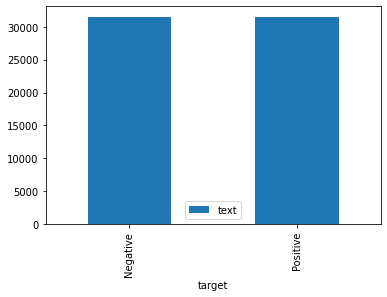

In [29]:
# The distribution of sentiments
df_news.groupby('target').count().plot(kind='bar')

In [30]:
import plotly.express as px

fig = px.pie(df_news, names='target', title ='Pie chart of different sentiments of tweets')
fig.show()

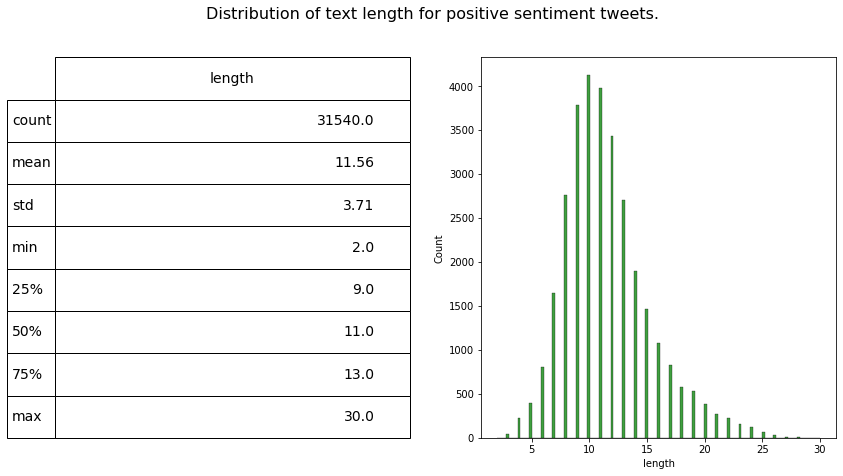

In [31]:
#Distribution of text length of Postive tweets

fig = plt.figure(figsize=(14,7))
df_news['length'] = df_news.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df_news[df_news['target']=='Positive']['length'], ax=ax1,color='green')
describe = df_news.length[df_news.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

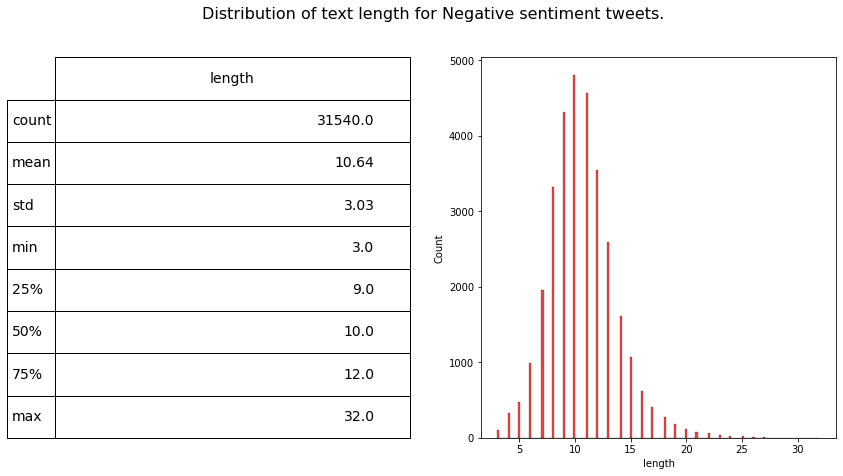

In [32]:
#Distribution of text length of Negative tweets

fig = plt.figure(figsize=(14,7))
df_news['length'] = df_news.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df_news[df_news['target']=='Negative']['length'], ax=ax1,color='red')
describe = df_news.length[df_news.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [33]:
df_news.drop(['length'], axis=1, inplace= True)
df_news.head()

,target,text
0,Negative,MP to study new Motor Act before implementing ...
1,Negative,Bhujbal says higher power rate driving industr...
2,Negative,Mandira Bedi shares a monochrome picture in a ...
3,Negative,Harassment in office DM seeks action taken re...
4,Negative,Two students end their lives mumbai


In [34]:
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator

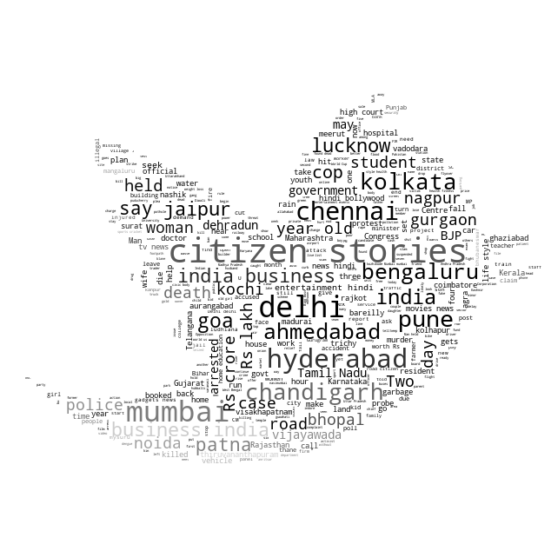

In [35]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_news[df_news.target == "Negative"]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(neg_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/neg_tweets_cloud.png')


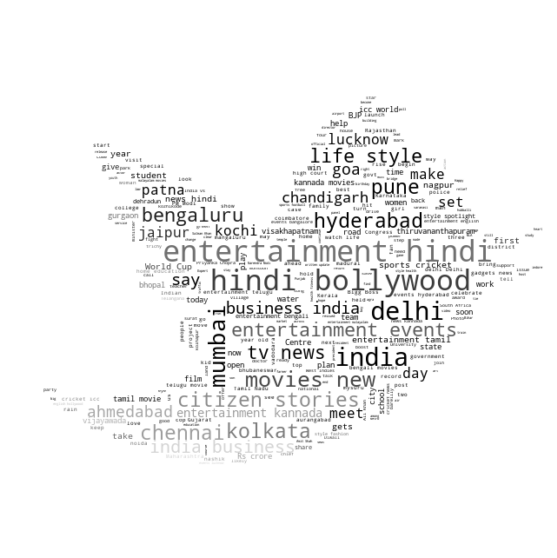

In [36]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_news[df_news.target == "Positive"]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want', 'im', 'u', 's', 'die', 'amp', 'one'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(pos_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/positive_tweets_cloud.png')

In [37]:

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df_news['text'][0])
print("\nProcessed tweet ->", tweet_to_words(df_news['text'][0]))


Original tweet -> MP to study new Motor Act before implementing it  CM Kamal Nath bhopal

Processed tweet -> ['mp', 'studi', 'new', 'motor', 'act', 'implement', 'cm', 'kamal', 'nath', 'bhopal']


In [39]:
X = list(map(tweet_to_words, df_news['text']))


In [40]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df_news['target'])

In [41]:
print(X[0])
print(Y[0])

['mp', 'studi', 'new', 'motor', 'act', 'implement', 'cm', 'kamal', 'nath', 'bhopal']
0


In [42]:
y = pd.get_dummies(df_news['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) #split into test and validation set

In [43]:
#Bag of words (BoW) extraction

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [44]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['0', '000', '1', '10', '100', '108', '10th', '11', '112', '12', '120', '13', '14', '144', '15', '150', '16', '17', '18', '19', '1st', '2', '20', '200', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2024', '21', '22', '23', '24', '24x7', '25', '250', '26', '27', '28', '29', '2nd', '3', '30', '300', '31', '32', '33', '34', '35', '350', '36', '37', '370', '38', '39', '3d', '3rd', '4', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '49', '4th', '5', '50', '500', '51', '52', '53', '54', '55', '550th', '56', '57', '58', '5g', '5th', '6', '60', '600', '61', '62', '63', '64', '65', '66', '66th', '67', '68', '69', '7', '70', '700', '71', '72', '73', '74', '75', '76', '77', '78', '7th', '8', '80', '800', '81', '82', '83', '84', '85', '86', '87', '9', '90', '900', '91', '92', '94', '95', '96', '98', '99', 'aadhaar', 'aaditya', 'aai', 'aap', 'aarey', 'aaryan', 'aayog', 'abandon', 'abduct', 'abet', 'abhaya', 'abhijit', 'abhishek', 'abl', 'ablaz', 'ab

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [45]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df_news['text'][0])
X, tokenizer = tokenize_pad_sequences(df_news['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 MP to study new Motor Act before implementing it  CM Kamal Nath bhopal
After Tokenization & Padding 
 [ 355    1  412   43 3061  324  342  108   90 1067 1156   79    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [46]:
#Saving tokenized data
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [47]:
y = pd.get_dummies(df_news['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (37848, 50) (37848, 2)
Validation Set -> (12616, 50) (12616, 2)
Test Set -> (12616, 50) (12616, 2)


In [48]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [49]:
# Bidirectional LSTM using NN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



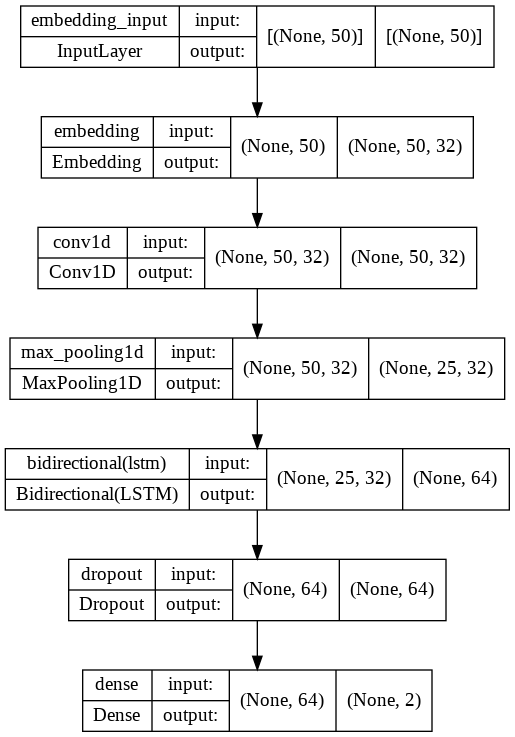

In [50]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [51]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 1

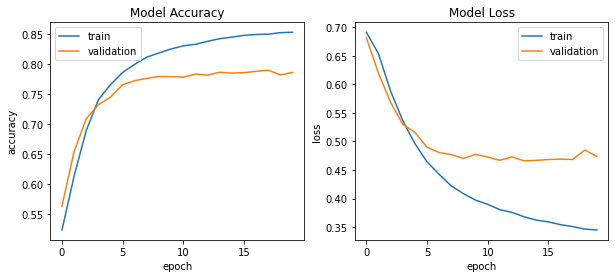

In [52]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

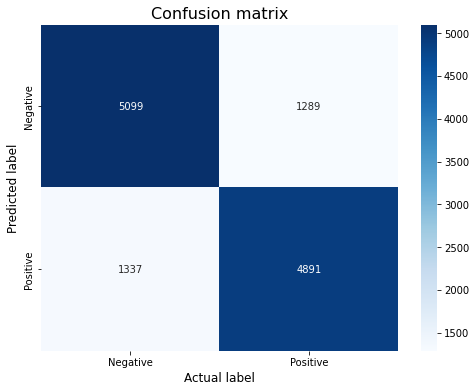

In [53]:
#Model confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [54]:
# Save the model architecture & the weights
model.save('timesofindia_lstm_model.h5')
print('Best model saved')

Best model saved


# **Aspect based sentiment**

In [55]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
def predict_aspect(text):
  # Importing the required libraries
  import spacy
  sp = spacy.load("en_core_web_sm")
  from textblob import TextBlob

  # Creating a list of positive and negative sentences.
  mixed_sen = [text]

  # An empty list for obtaining the extracted aspects
  # from sentences.
  ext_aspects = []

  # Performing Aspect Extraction
  for sen in mixed_sen:
    important = sp(sen)
    descriptive_item = ''
    target = ''
    for token in important:
      if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
        target = token.text
      if token.pos_ == 'ADJ':
        added_terms = ''
        for mini_token in token.children:
          if mini_token.pos_ != 'ADV':
            continue
          added_terms += mini_token.text + ' '
        descriptive_item = added_terms + token.text 
    ext_aspects.append({'aspect': target,'description': descriptive_item})

  print("ASPECT EXTRACTION\n")
  print(ext_aspects)


  for aspect in ext_aspects:
    aspect['sentiment'] = TextBlob(aspect['description']).sentiment

  print("\n")
  print("\nSENTIMENT ASSOCIATION\n")
  print(ext_aspects)


In [57]:
from keras.models import load_model

# Load model
model = load_model('timesofindia_lstm_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

    

    #for apspect based sentiment prediction
    # converting list to string type
    str1 = " " 
    
    # return string  
    txt= str1.join(text)
    predict_aspect(txt)

   

## **Predicting**

In [58]:
predict_class(['the battery of phone is bad'])


The predicted sentiment is Negative
ASPECT EXTRACTION

[{'aspect': 'battery', 'description': 'bad'}]



SENTIMENT ASSOCIATION

[{'aspect': 'battery', 'description': 'bad', 'sentiment': Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)}]


In [59]:
predict_class(['He is the worst minister india ever had seen'])

The predicted sentiment is Negative
ASPECT EXTRACTION

[{'aspect': '', 'description': 'worst'}]



SENTIMENT ASSOCIATION

[{'aspect': '', 'description': 'worst', 'sentiment': Sentiment(polarity=-1.0, subjectivity=1.0)}]


In [60]:
predict_class(["i am feeling ill"])

The predicted sentiment is Negative
ASPECT EXTRACTION

[{'aspect': '', 'description': 'ill'}]



SENTIMENT ASSOCIATION

[{'aspect': '', 'description': 'ill', 'sentiment': Sentiment(polarity=-0.5, subjectivity=1.0)}]


In [61]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_trigram(df_news.text, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [62]:
trigram

,trigram,count
0,entertainment hindi bollywood,2746
1,business india business,1774
2,tv news hindi,726
3,entertainment tamil movies,453
4,tamil movies news,453
5,entertainment kannada movies,430
6,kannada movies news,424
7,icc world cup,370
8,life style spotlight,322
9,entertainment events hyderabad,309


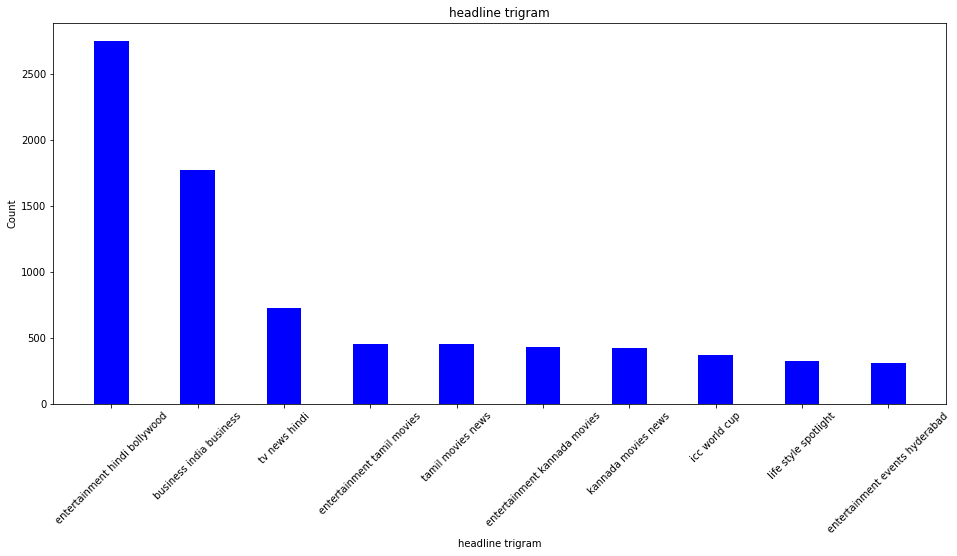

In [63]:
fig= plt.figure(figsize=(16,7))

xaxis = trigram['trigram']
yaxis = trigram['count']
                         
plt.bar(xaxis, yaxis, width=0.4, color='blue')

plt.xlabel("headline trigram")
plt.ylabel("Count")
plt.title("headline trigram")
plt.xticks(rotation=45)
plt.show()

# **Topic Modeling**

In [64]:
#create a document-term matrix to create vocabulary of all the words in tweets data
#Each of 52615 documents is represented as 5000 dimensional vectors, which means that our vocabulary has 5000 words.

from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=1,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{1,}',# num chars > 3
max_features=40000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(df_news.text)
data_matrix

<63080x37414 sparse matrix of type '<class 'numpy.int64'>'
	with 533539 stored elements in Compressed Sparse Row format>

In [65]:
lda_model = LatentDirichletAllocation(
n_components=12, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = 1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [66]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=22f49d321e2ee9680c78110ba5f43e981403a79fbf4592fe15f18ab69e38a846
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [67]:
# extract information from a fitted LDA topic model to inform an interactive web-based visualization

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0        5.310529  171.049652       1        1  11.378282
9      136.304657   23.800941       2        1   9.175489
11     101.190552  -84.985191       3        1   9.071500
5     -106.824867  148.841736       4        1   8.690689
10     -44.365761   78.632721       5        1   8.505880
7       43.884090   73.474022       6        1   8.190917
8      114.093971  135.933029       7        1   7.939296
3     -119.727142  -72.077179       8        1   7.866305
6      -49.518208   -9.617325       9        1   7.483735
1     -141.938736   40.055210      10        1   7.324147
4       38.731544  -14.776019      11        1   7.211456
2      -10.944340 -107.193344      12        1   7.162305, topic_info=                Term         Freq        Total Category  logprob  loglift
16112          india  6967.000000  6967.000000  Default  30.0000  30.0000
9369           delhi  4875.000000  4875.000000  Default  29.0000  29.0000
11491  entertainment  6533.000000  6533.000000  Default  28.0000  28.0000
22206         mumbai  3623.000000  3623.000000  Default  27.0000  27.0000
5978        business  3490.000000  3490.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
18734      kozhikode   241.084834   309.408640  Topic12  -5.1030   2.3868
2016           ahead   206.497706   298.757239  Topic12  -5.2579   2.2670
6895           check   195.999495   256.464637  Topic12  -5.3100   2.3675
29044              s   319.901504  7202.515799  Topic12  -4.8201  -0.4778
23041           news   267.511938  3818.736092  Topic12  -4.9990  -0.0222

[450 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
2          2  0.449677    000
2          5  0.340624    000
2         12  0.208683    000
57         2  0.608547      1
57         8  0.243927      1
...      ...       ...    ...
37026     10  0.999727  world
37055      5  0.995107  worth
37213      5  0.999583   year
37217      2  0.999375  years
37281      4  0.996576  youth

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 12, 6, 11, 8, 9, 4, 7, 2, 5, 3])

In [68]:
#keep the top 10 most frequent words from each topic that found by LDA

for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['kapoor', 'khan', 'events', 'style', 's', 'life', 'pune', 'bollywood', 'hindi', 'entertainment']


Top 10 words for topic #1:
['icc', 'hit', 'south', 's', 'cup', 'work', 'cricket', 'world', 'chennai', 'sports']


Top 10 words for topic #2:
['s', 'free', 'win', 'gadgets', '3', 'gurgaon', 'maharashtra', 'thiruvananthapuram', 'today', 'mumbai']


Top 10 words for topic #3:
['west', 'nadu', '5', 'visakhapatnam', 't', 'water', 'chennai', 'new', 'tamil', 'kolkata']


Top 10 words for topic #4:
['nashik', 'coimbatore', 'hc', 'cops', 'says', 's', 'cm', 'day', 'government', 'nagpur']


Top 10 words for topic #5:
['madurai', 'congress', 'high', 'road', 'bjp', 'court', 'goa', 'hyderabad', 'citizen', 'stories']


Top 10 words for topic #6:
['photos', 'mysuru', 'karnataka', 'kerala', 'education', 'set', 's', 'kochi', 'india', 'bengaluru']


Top 10 words for topic #7:
['minister', 'centre', 'new', 'chief', 'bhopal', 'university', 's', 'police', '2', 'delhi']


Top 10 words for topic #8:
['pm', '10'

In [69]:
#add a new created topic column to the input dataframe and assign to each row ,based on the probability value, the suitable topic. To 
#find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.

topic_values = lda_model.transform(data_matrix)
df_news['Topic'] = topic_values.argmax(axis=1)

In [70]:
df_topic=df_news
df_topic

,target,text,Topic
0,Negative,MP to study new Motor Act before implementing ...,7
1,Negative,Bhujbal says higher power rate driving industr...,4
2,Negative,Mandira Bedi shares a monochrome picture in a ...,0
3,Negative,Harassment in office DM seeks action taken re...,8
4,Negative,Two students end their lives mumbai,9
...,...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...,6
63076,Positive,40;000 cops to ensure safe New Year celebratio...,10
63077,Positive,Ten more private trains from Mumbai on cards m...,2
63078,Positive,A trip to a tribal village with super cop Vija...,3


In [71]:
df_topic.to_csv('Dataset_For_Project/timesofindia_with_topic_12.csv', index = False, encoding='utf-8')

In [72]:
df_topic.dtypes

target    object
text      object
Topic      int64
dtype: object

In [73]:
df_topic.Topic = df_topic.Topic.astype(str)


In [74]:
df_topic.dtypes

target    object
text      object
Topic     object
dtype: object

In [75]:
df_topic.to_csv('Dataset_For_Project/timesofindia_with_topic_12.csv', index = False, encoding='utf-8')

## **Training topic dataset using LSTM**

# **LSA**

In [76]:
from tqdm import tqdm
from collections import Counter
import ast
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [77]:
reindexed_data=df_news.text
n_topics=12

In [78]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: Don't need consent from Tamil Nadu for Mekedatu dam; says Karnataka chennai
Headline after vectorization: 
  (0, 4343)	1
  (0, 9342)	1
  (0, 2830)	1
  (0, 12204)	1
  (0, 13825)	1
  (0, 9192)	1
  (0, 3286)	1
  (0, 8697)	1
  (0, 3667)	1
  (0, 7396)	1


In [79]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

In [80]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

In [81]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [82]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [83]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
      topic_words = []
      for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
      top_words.append(" ".join(topic_words))         
    return top_words

In [84]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  india business pm modi rs sc says govt bjp new
Topic 2:  entertainment hindi bollywood news movies events tv khan music kannada
Topic 3:  delhi government kejriwal air noida arvind police new aap university
Topic 4:  citizen stories road garbage water parking open footpath traffic sewage
Topic 5:  mumbai held rs woman maharashtra man lakh crore gets surat
Topic 6:  news tv gadgets kannada cricket update sports telugu 2019 bigg
Topic 7:  hyderabad ahmedabad chandigarh goa lucknow patna jaipur year nagpur new
Topic 8:  sports world 2019 cup cricket icc india vs home pakistan
Topic 9:  chennai tamil nadu water noida coimbatore madurai madras residents corporation
Topic 10:  pune maharashtra rs water year man new lakh old pmc
Topic 11:  kolkata bengaluru kochi home karnataka kerala patna chandigarh bengal education
Topic 12:  style life health spotlight fitness fashion weight news books loss


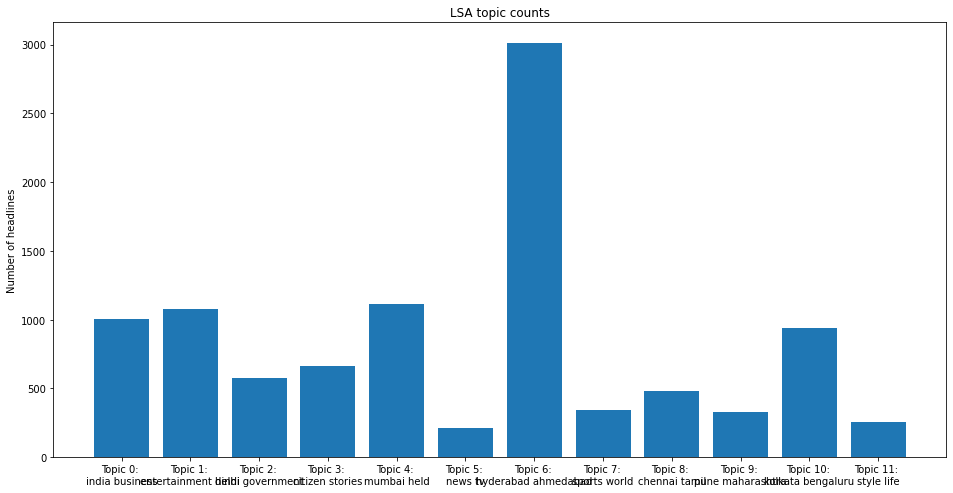

In [85]:
top_3_words = get_top_n_words(2, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [86]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.023s...
[t-SNE] Computed neighbors for 10000 samples in 2.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.013167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.282166
[t-SNE] KL divergence after 2000 iterations: 0.731798


In [87]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [88]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [89]:
top_3_words_lsa = get_top_n_words(2, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

## **LDA**

In [90]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [91]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [92]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  pune nagpur gurgaon india maharashtra rs mumbai gurugram singh 000
Topic 2:  india business entertainment bollywood hindi mumbai khan rs home kapoor
Topic 3:  stories citizen kolkata road noida man trichy garbage police mumbai
Topic 4:  goa patna rs crore cm mumbai bihar pune india worth
Topic 5:  hyderabad kochi telangana madurai kerala water coimbatore india woman chennai
Topic 6:  delhi ahmedabad year old government gujarat dehradun university india mumbai
Topic 7:  entertainment news movies chandigarh kannada music tamil bengali kolhapur events
Topic 8:  bengaluru chennai tamil nadu bhopal thiruvananthapuram india nashik mysuru surat
Topic 9:  chennai kolkata vijayawada new india bjp vadodara mumbai mangaluru hyderabad
Topic 10:  sports india jaipur world cricket cup 2019 icc rajasthan today
Topic 11:  style life events entertainment news chandigarh health day gadgets spotlight
Topic 12:  news tv hindi lucknow entertainment bollywood telugu visakhapatnam update bigg


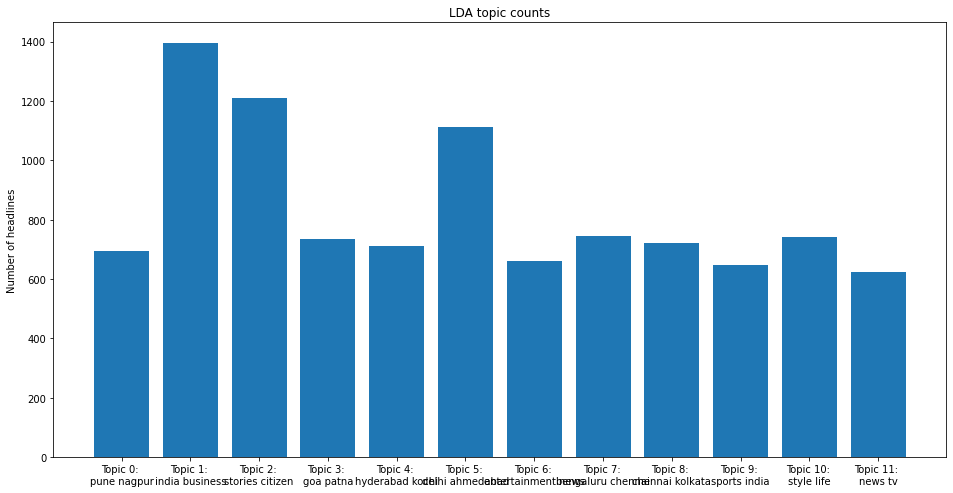

In [93]:
top_3_words = get_top_n_words(2, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [94]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 2.191s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.987915
[t-SNE] KL divergence after 2000 iterations: 1.763490


In [97]:
top_3_words_lda = get_top_n_words(2, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color='black')
    plot.add_layout(label)

show(plot)